## Prepare Data

100%|██████████| 1657/1657 [00:25<00:00, 63.97it/s]
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


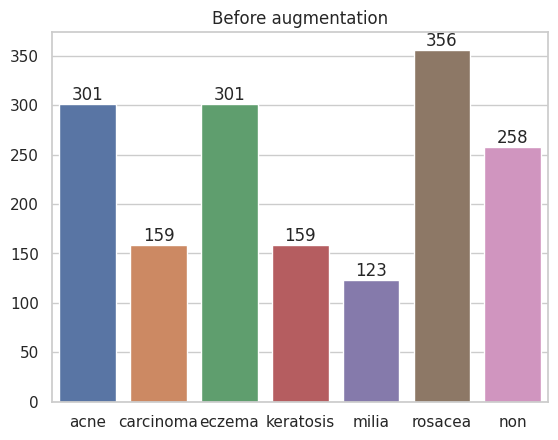

In [1]:

import os
import pickle
import numpy as np
import seaborn as sns
from tqdm import tqdm
import tensorflow.keras as K
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import img_to_array
from pathlib import Path
from skimage.transform import rotate

img_path = os.listdir('../input/ecz-data')

features = []
labels = []
dict = {'acne': 0, 'carcinoma': 1, 'eczema': 2, 'keratosis': 3, 'milia': 4, 'rosacea': 5, 'non': 6}
for i in tqdm(img_path):
    fname = os.path.join('../input/ecz-data', i)
    img = image.load_img(fname, target_size=(299, 299))
    x = img_to_array(img)
    x = K.applications.xception.preprocess_input(x)
    features.append(x)
    y = i.split(".")[0]
#     print(y, dict[y])
    labels.append(dict[y])

features = np.array(features)
labels = np.array(labels)

lbl, count = np.unique(labels, return_counts=True)                                            # plot a bar plot to show the quantity of images in each class
temp = {0: 'acne', 1: 'carcinoma', 2: 'eczema', 3: 'keratosis', 4: 'milia', 5: 'rosacea', 6: 'non'}
count_lbl = {}
for i in range(len(lbl)):
    count_lbl[temp[lbl[i]]] = count[i]
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=list(count_lbl.keys()), y=list(count_lbl.values()))
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Before augmentation')
plt.show()

indices = np.random.permutation(len(features))
features = features[indices]
labels = labels[indices]

x_train, y_train, rx_test, ry_test, x_val, y_val, x_test, y_test = [], [], [], [], [], [], [], []

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)       
for train_index, r_index in split.split(features, labels):
    x_train, rx_test = features[train_index], features[r_index]
    y_train, ry_test = labels[train_index], labels[r_index]

split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=0)     
for val_index, test_index in split.split(rx_test, ry_test):
    x_val, x_test = rx_test[val_index], rx_test[test_index]
    y_val, y_test = ry_test[val_index], ry_test[test_index]

split_dir = Path('splits')
split_dir.mkdir(exist_ok=True)

def save_data(file_name, data):
    file_path = split_dir / file_name
    try:
        with file_path.open('wb') as f:
            pickle.dump(data, f)
    except Exception as e:
        print(f"Error saving {file_name}: {e}")

save_data('x_train', x_train)
save_data('y_train', y_train)
save_data('x_val', x_val)
save_data('y_val', y_val)
save_data('x_test', x_test)
save_data('y_test', y_test)

## Augment

In [2]:
os.listdir('.')

['models',
 'model.png',
 '.virtual_documents',
 'augmented_data',
 'state.db',
 'splits']

In [3]:
x_train = pickle.load(open('splits/x_train', 'rb'))
y_train = pickle.load(open('splits/y_train', 'rb'))
x_val = pickle.load(open('splits/x_val', 'rb'))
y_val = pickle.load(open('splits/y_val', 'rb'))
x_test = pickle.load(open('splits/x_test', 'rb'))
y_test = pickle.load(open('splits/y_test', 'rb'))

x_t = len(x_train)
x_copy = x_train.copy()
count = 0
ecz, ker, ros = 0, 0, 0
for i in tqdm(range(x_t)):
    if y_train[i] == 0:
        x_train = np.append(x_train, [rotate(x_copy[i], angle=45, mode='wrap')], axis=0)
        y_train = np.append(y_train, 0)

    elif y_train[i] == 2:
        if ecz % 3 == 0:
            x_train = np.append(x_train, [rotate(x_copy[i], angle=45, mode='wrap')], axis=0)
            x_train = np.append(x_train, [np.flipud(x_copy[i])], axis=0)
            for j in range(2):
                y_train = np.append(y_train, 2)
        ecz += 1

    elif y_train[i] == 3:
        if ker % 6 == 0:
            x_train = np.append(x_train, [rotate(x_copy[i], angle=45, mode='wrap')], axis=0)
            x_train = np.append(x_train, [np.flipud(x_copy[i])], axis=0)
            for j in range(2):
                y_train = np.append(y_train, 3)
        ker += 1

    elif y_train[i] == 4:
        x_train = np.append(x_train, [rotate(x_copy[i], angle=45, mode='wrap')], axis=0)
        x_train = np.append(x_train, [np.flipud(x_copy[i])], axis=0)
        x_train = np.append(x_train, [np.fliplr(x_copy[i])], axis=0)
        x_train = np.append(x_train, [rotate(np.fliplr(x_copy[i]), angle=270, mode='wrap')], axis=0)
        for j in range(4):
            y_train = np.append(y_train, 4)

    elif y_train[i] == 5:
        if ros % 9 == 0:
            x_train = np.append(x_train, [rotate(x_copy[i], angle=45, mode='wrap')], axis=0)
            x_train = np.append(x_train, [np.flipud(x_copy[i])], axis=0)
            for j in range(2):
                y_train = np.append(y_train, 5)
        ros += 1

indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]


def save_data(data, filename, directory="augmented_data"):
    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, filename)
    with open(filepath, "wb") as f:
        pickle.dump(data, f)

save_data(x_train, "x_train")
save_data(y_train, "y_train")
save_data(x_val, "x_val")
save_data(y_val, "y_val")
save_data(x_test, "x_test")
save_data(y_test, "y_test")

100%|██████████| 1325/1325 [10:43<00:00,  2.06it/s]


## Train

In [4]:
os.listdir(".")

['models',
 'model.png',
 '.virtual_documents',
 'augmented_data',
 'state.db',
 'splits']

In [13]:
import pickle
from tensorflow.keras import Model
# from keras import Model
import tensorflow.keras as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense, Dropout
import tensorflow as tf

x_train = pickle.load(open('augmented_data/x_train', 'rb'))
y_train = pickle.load(open('augmented_data/y_train', 'rb'))
x_val = pickle.load(open('splits/x_val', 'rb'))
y_val = pickle.load(open('splits/y_val', 'rb'))
x_test = pickle.load(open('splits/x_test', 'rb'))
y_test = pickle.load(open('splits/y_test', 'rb'))





base_model = K.applications.Xception(include_top=False,
                                     weights='imagenet',
                                     input_tensor=None,
                                     input_shape=(299, 299, 3),
                                     pooling=None,
                                     classifier_activation="softmax",
                                     )
base_model.trainable = False

inputs = K.Input(shape=(299, 299, 3))

x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

outputs = Dense(7, activation='softmax')(x)         
opt = Adam(learning_rate=0.001)


model = Model(inputs, outputs)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

acc_checkpoint = ModelCheckpoint("models/first_train/max_acc/model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
loss_checkpoint = ModelCheckpoint("models/first_train/min_loss/model.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [acc_checkpoint, loss_checkpoint]



hist = model.fit(x_train, y_train, epochs=15, validation_data=(x_val, y_val), batch_size=32, callbacks=callbacks_list)

with open('models/first_train/hist', 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)


base_model.trainable = True

opt = Adam(learning_rate=0.00001)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

acc_checkpoint = ModelCheckpoint("models/second_train/max_acc/model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
loss_checkpoint = ModelCheckpoint("models/second_train/min_loss/model.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [acc_checkpoint, loss_checkpoint]

hist = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), batch_size=32, callbacks=callbacks_list)

with open('models/second_train/hist', 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)


Epoch 1/15


W0000 00:00:1715243887.704989     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.4736 - loss: 1.6605

W0000 00:00:1715243909.028937     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715243913.258518     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.63121, saving model to models/first_train/max_acc/model.keras


W0000 00:00:1715243916.603647     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 1.13505, saving model to models/first_train/min_loss/model.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 45s 438ms/step - accuracy: 0.4755 - loss: 1.6541 - val_accuracy: 0.6312 - val_loss: 1.1351
Epoch 2/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7793 - loss: 0.6450
Epoch 2: val_accuracy improved from 0.63121 to 0.73759, saving model to models/first_train/max_acc/model.keras

Epoch 2: val_loss improved from 1.13505 to 0.88114, saving model to models/first_train/min_loss/model.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 233ms/step - accuracy: 0.7796 - loss: 0.6445 - val_accuracy: 0.7376 - val_loss: 0.8811
Epoch 3/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8414 - loss: 0.4556
Epoch 3: val_accuracy did not improve from 0.73759

Epoch 3: val_loss improved from 0.88114 to 0.71933, saving model to models/first_train/min_loss/model.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 225ms/step - accuracy: 0.8413 - loss: 0.4557 - val_accuracy: 0.7234 - val_lo

W0000 00:00:1715244250.330058     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.6684 - loss: 1.4397

W0000 00:00:1715244356.531972     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6687 - loss: 1.4372   

W0000 00:00:1715244361.103279     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.84043, saving model to models/second_train/max_acc/model.keras


W0000 00:00:1715244364.469163     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.61564, saving model to models/second_train/min_loss/model.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.6691 - loss: 1.4348 - val_accuracy: 0.8404 - val_loss: 0.6156
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.7917 - loss: 0.7168
Epoch 2: val_accuracy improved from 0.84043 to 0.84397, saving model to models/second_train/max_acc/model.keras

Epoch 2: val_loss did not improve from 0.61564
70/70 ━━━━━━━━━━━━━━━━━━━━ 52s 745ms/step - accuracy: 0.7916 - loss: 0.7172 - val_accuracy: 0.8440 - val_loss: 0.6549
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.8405 - loss: 0.5497
Epoch 3: val_accuracy improved from 0.84397 to 0.86879, saving model to models/second_train/max_acc/model.keras

Epoch 3: val_loss did not improve from 0.61564
70/70 ━━━━━━━━━━━━━━━━━━━━ 53s 756ms/step - accuracy: 0.8406 - loss: 0.5493 - val_accuracy: 0.8688 - val_loss: 0.6249
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/ste

## Eval

1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

W0000 00:00:1715245256.898634     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 16s/step


W0000 00:00:1715245272.930577     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

W0000 00:00:1715245283.096917     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


W0000 00:00:1715245286.115963     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

W0000 00:00:1715245300.431503     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


W0000 00:00:1715245303.438776     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

W0000 00:00:1715245319.054198     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step


W0000 00:00:1715245322.097134     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

W0000 00:00:1715245332.252069     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


W0000 00:00:1715245335.262933     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Model: models/first_train/max_acc/model.keras
Confusion Matrix
 [[6 0 0 0 2 1 0]
 [0 4 0 1 0 0 0]
 [0 0 8 0 0 1 0]
 [0 1 0 4 0 0 0]
 [0 0 0 0 4 0 0]
 [1 0 0 0 0 9 0]
 [0 0 0 0 0 0 8]]


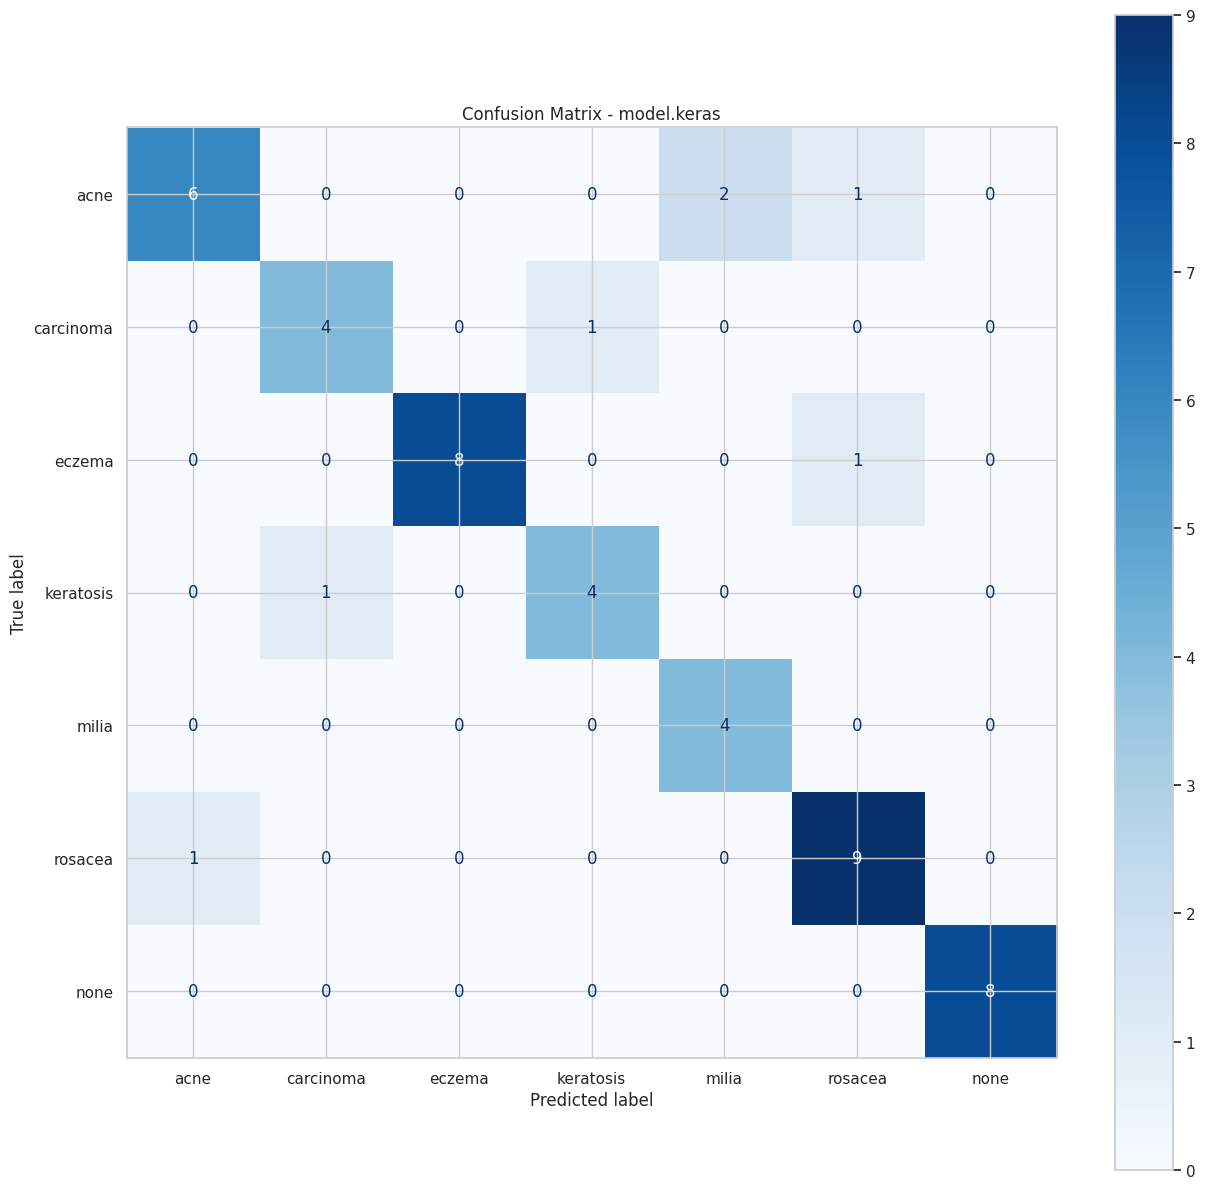

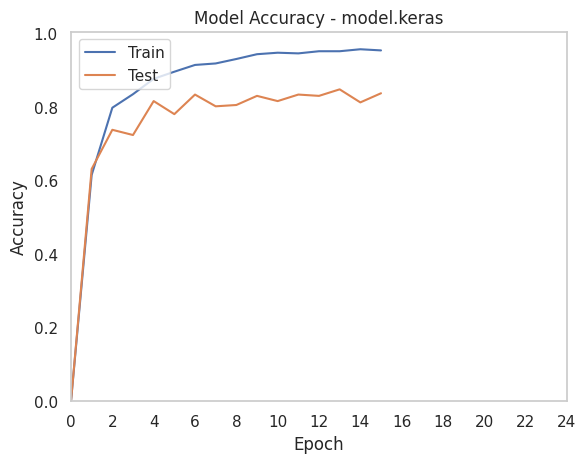

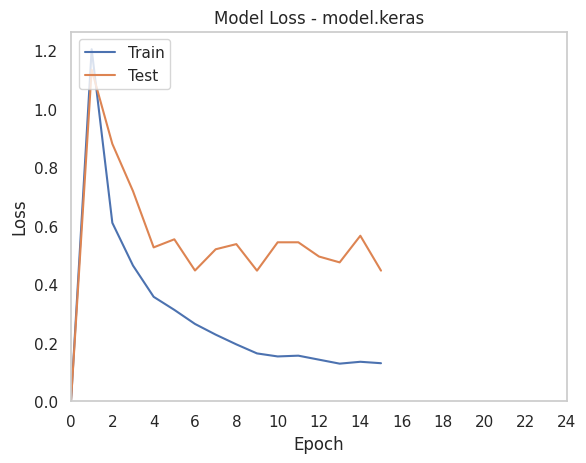

acne - 66.67%
carcinoma - 80.00%
eczema - 88.89%
keratosis - 80.00%
milia - 100.00%
rosacea - 90.00%

classification_report: 
              precision    recall  f1-score   support

           0       0.86      0.67      0.75         9
           1       0.80      0.80      0.80         5
           2       1.00      0.89      0.94         9
           3       0.80      0.80      0.80         5
           4       0.67      1.00      0.80         4
           5       0.82      0.90      0.86        10
           6       1.00      1.00      1.00         8

    accuracy                           0.86        50
   macro avg       0.85      0.87      0.85        50
weighted avg       0.87      0.86      0.86        50

--------------------------------------------------
1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

W0000 00:00:1715245347.142419     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


W0000 00:00:1715245350.157237     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Model: models/first_train/min_loss/model.keras
Confusion Matrix
 [[7 0 0 0 1 1 0]
 [0 3 1 1 0 0 0]
 [0 0 7 0 1 1 0]
 [0 1 0 4 0 0 0]
 [0 0 0 0 4 0 0]
 [1 0 1 0 0 8 0]
 [0 0 0 0 0 0 8]]


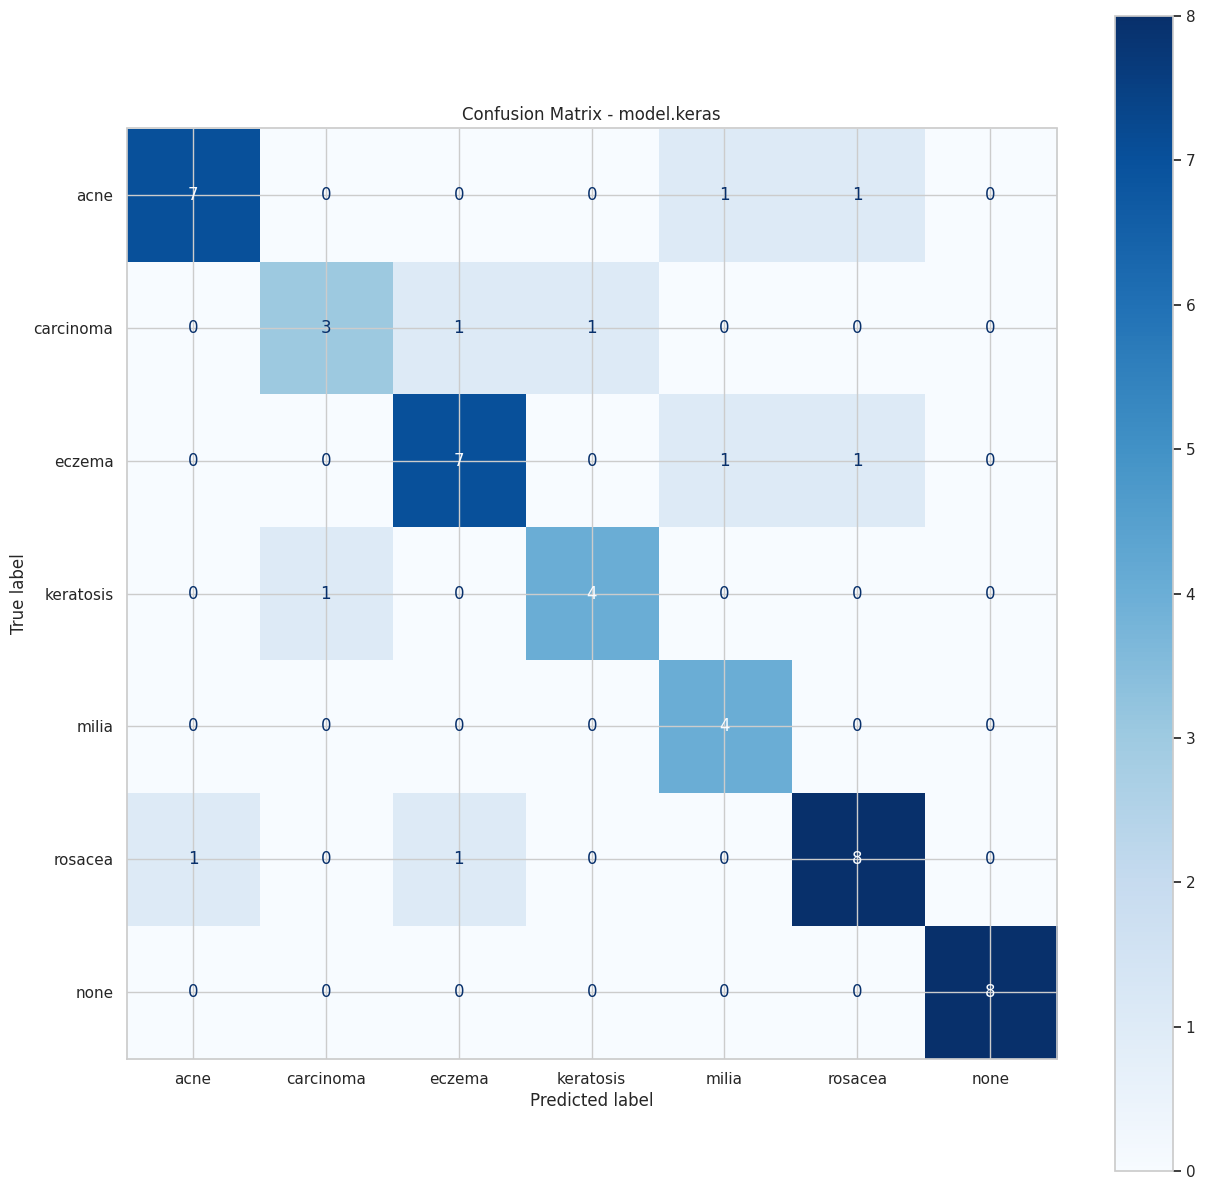

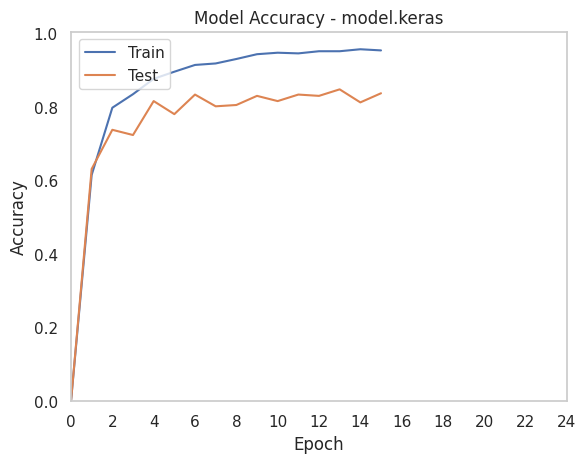

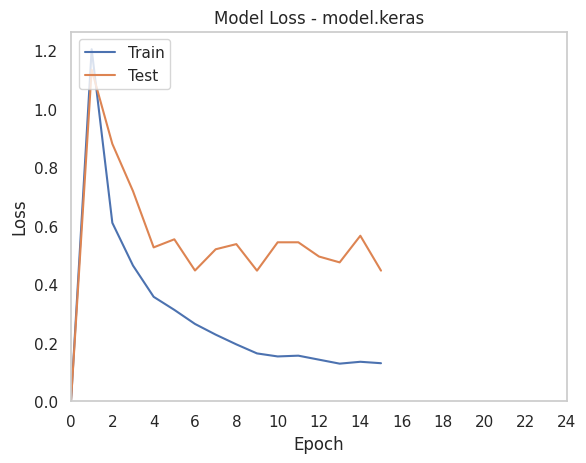

acne - 77.78%
carcinoma - 60.00%
eczema - 77.78%
keratosis - 80.00%
milia - 100.00%
rosacea - 80.00%

classification_report: 
              precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       0.75      0.60      0.67         5
           2       0.78      0.78      0.78         9
           3       0.80      0.80      0.80         5
           4       0.67      1.00      0.80         4
           5       0.80      0.80      0.80        10
           6       1.00      1.00      1.00         8

    accuracy                           0.82        50
   macro avg       0.81      0.82      0.81        50
weighted avg       0.83      0.82      0.82        50

--------------------------------------------------
1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

W0000 00:00:1715245366.123441     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


W0000 00:00:1715245369.161110     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Model: models/second_train/max_acc/model.keras
Confusion Matrix
 [[6 1 0 0 1 1 0]
 [0 3 0 1 0 1 0]
 [0 0 7 0 2 0 0]
 [0 0 0 5 0 0 0]
 [0 0 0 0 4 0 0]
 [0 0 0 0 1 9 0]
 [0 0 0 1 0 0 7]]


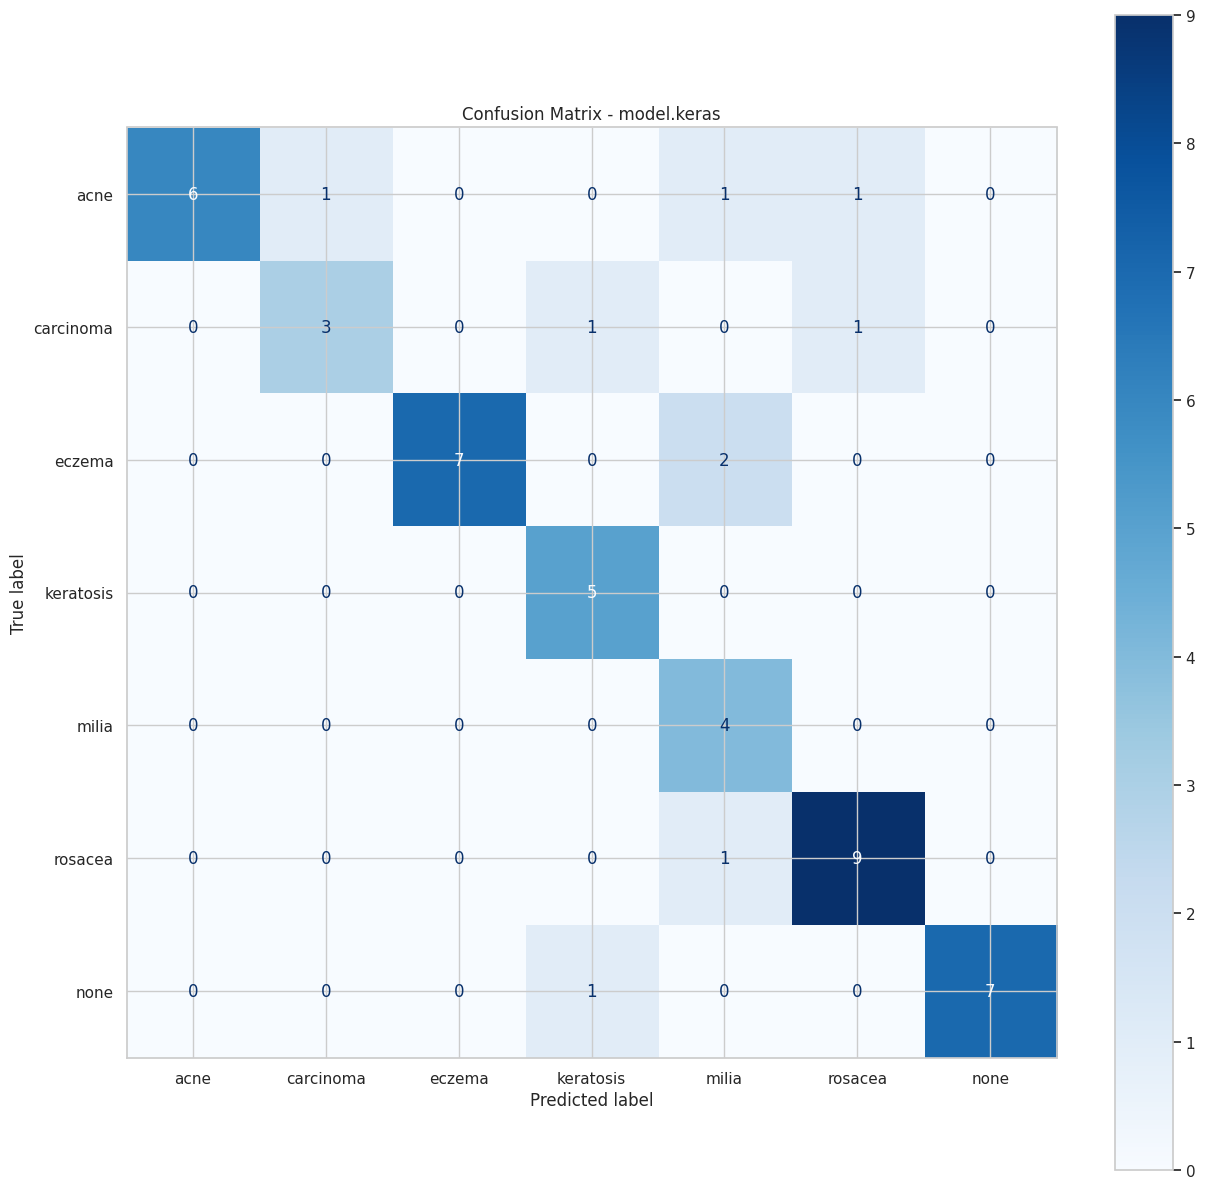

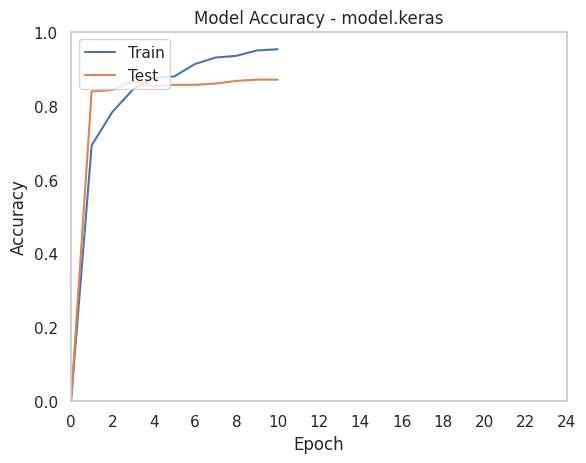

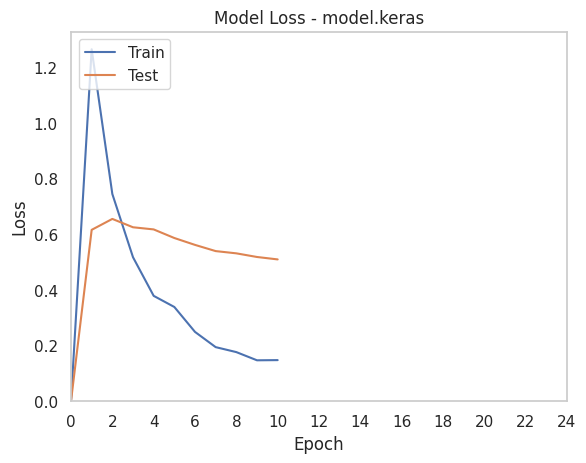

acne - 66.67%
carcinoma - 60.00%
eczema - 77.78%
keratosis - 100.00%
milia - 100.00%
rosacea - 90.00%

classification_report: 
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         9
           1       0.75      0.60      0.67         5
           2       1.00      0.78      0.88         9
           3       0.71      1.00      0.83         5
           4       0.50      1.00      0.67         4
           5       0.82      0.90      0.86        10
           6       1.00      0.88      0.93         8

    accuracy                           0.82        50
   macro avg       0.83      0.83      0.80        50
weighted avg       0.87      0.82      0.83        50

--------------------------------------------------
1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

W0000 00:00:1715245385.154890     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


W0000 00:00:1715245388.230556     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Model: models/second_train/min_loss/model.keras
Confusion Matrix
 [[6 1 0 0 1 1 0]
 [0 3 0 1 0 1 0]
 [0 0 7 0 2 0 0]
 [0 0 0 5 0 0 0]
 [0 0 0 0 4 0 0]
 [0 0 0 0 1 9 0]
 [0 0 0 1 0 0 7]]


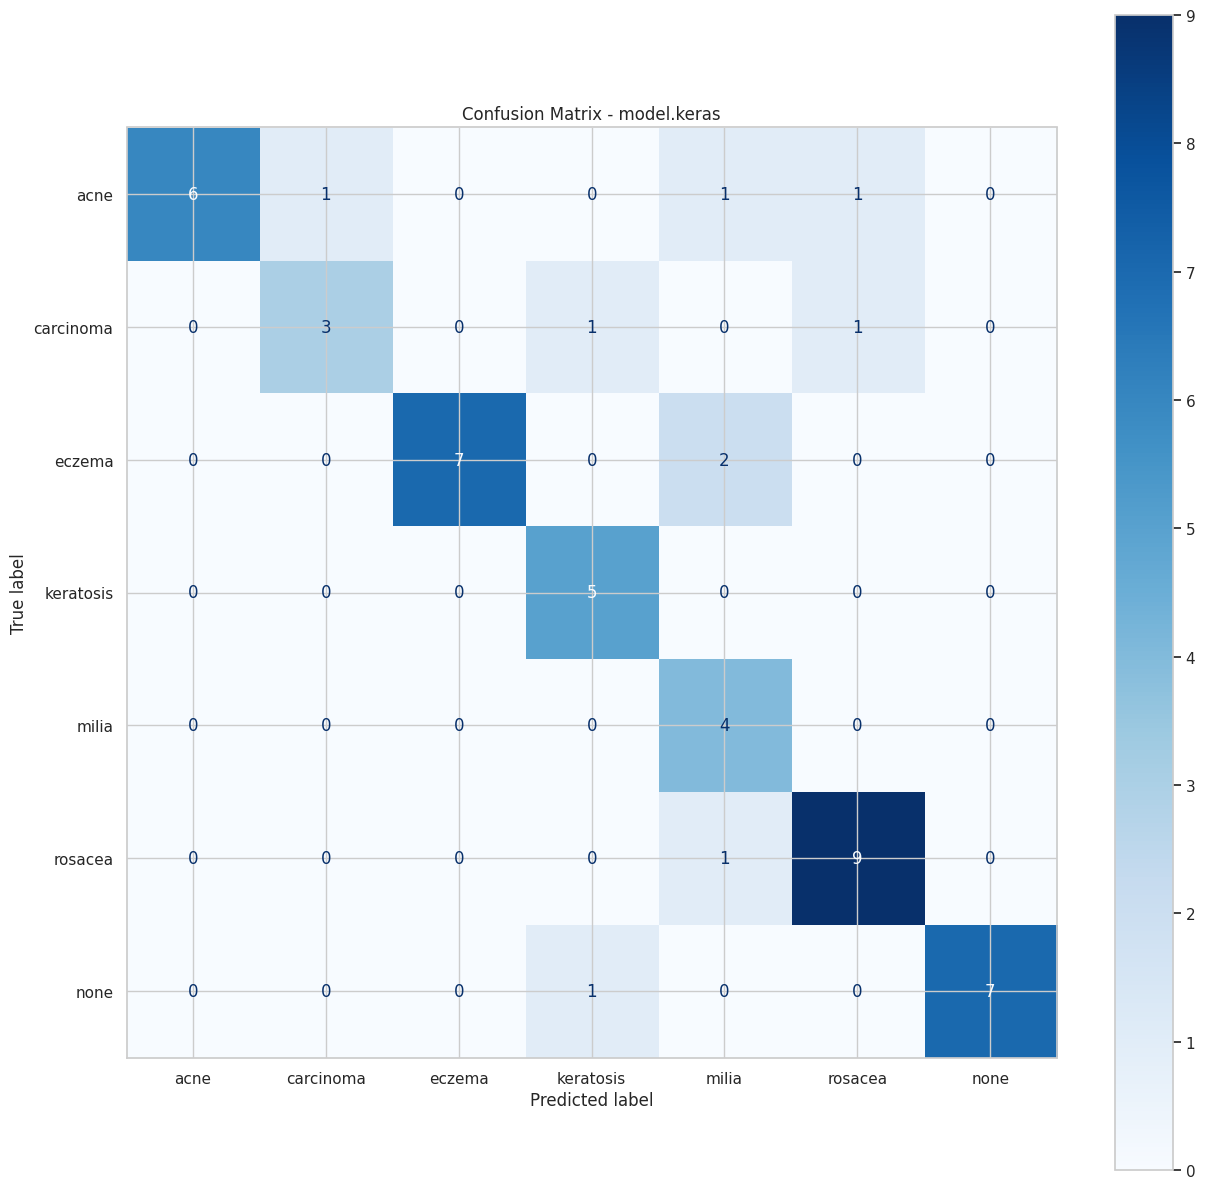

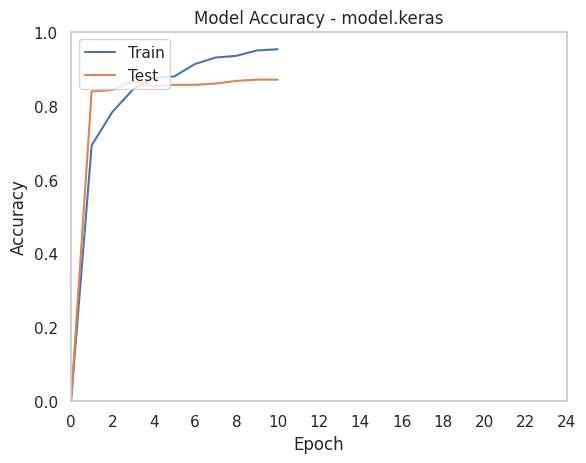

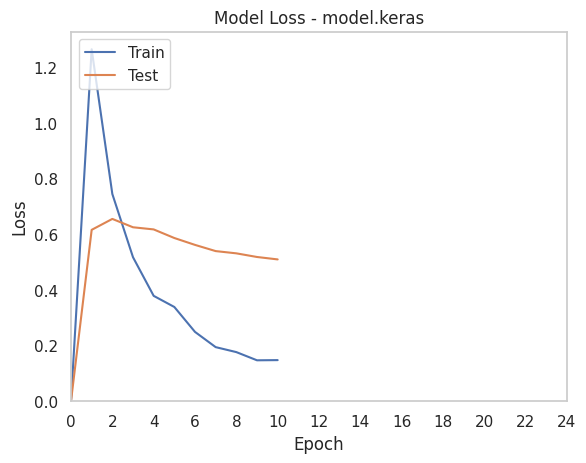

acne - 66.67%
carcinoma - 60.00%
eczema - 77.78%
keratosis - 100.00%
milia - 100.00%
rosacea - 90.00%

classification_report: 
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         9
           1       0.75      0.60      0.67         5
           2       1.00      0.78      0.88         9
           3       0.71      1.00      0.83         5
           4       0.50      1.00      0.67         4
           5       0.82      0.90      0.86        10
           6       1.00      0.88      0.93         8

    accuracy                           0.82        50
   macro avg       0.83      0.83      0.80        50
weighted avg       0.87      0.82      0.83        50

--------------------------------------------------
Ensemble Model:
Confusion Matrix
 [[6 1 0 0 1 1 0]
 [0 3 0 1 0 1 0]
 [0 0 7 0 1 1 0]
 [0 0 0 5 0 0 0]
 [0 0 0 0 4 0 0]
 [0 0 0 0 1 9 0]
 [0 0 0 0 0 0 8]]


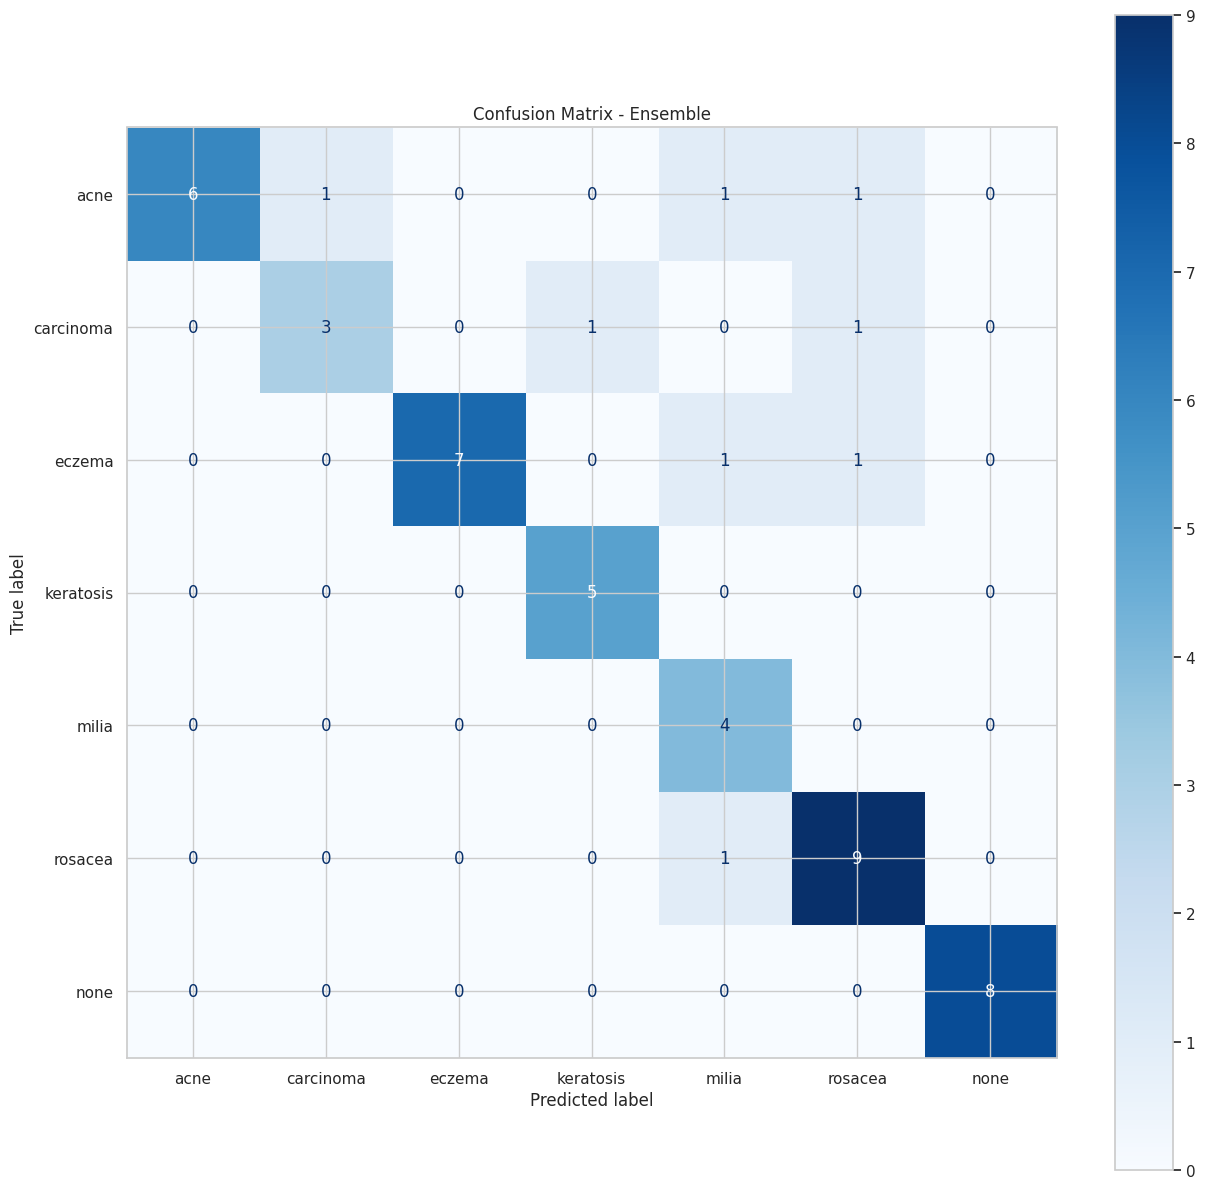

In [15]:
import tensorflow.keras as K
import pickle
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix, classification_report)


model_paths = [
    "models/first_train/max_acc/model.keras",
    "models/first_train/min_loss/model.keras",
    "models/second_train/max_acc/model.keras",
    "models/second_train/min_loss/model.keras",
]
hist_paths = [
    "models/first_train/hist",
    "models/first_train/hist",
    "models/second_train/hist",
    "models/second_train/hist",
]

x_test = pickle.load(open('splits/x_test', 'rb'))
y_test = pickle.load(open('splits/y_test', 'rb'))
types = ['acne', 'carcinoma', 'eczema', 'keratosis', 'milia', 'rosacea', 'none']

all_predictions = []
for model_path in model_paths:
    model = K.models.load_model(model_path)
    predictions = model.predict(x_test)
    all_predictions.append(predictions)

ensemble_predictions = np.mean(all_predictions, axis=0)
ensemble_pred_labels = np.argmax(ensemble_predictions, axis=1)

for model_path, hist_path in zip(model_paths, hist_paths):
    model = K.models.load_model(model_path)
    with open(hist_path, "rb") as file_pi:
        hist = pickle.load(file_pi)

    predictions = model.predict(x_test)
    test_pred = np.argmax(predictions, axis=1)

    # Evaluation metrics
    cm = confusion_matrix(y_test, test_pred)
    print(f"Model: {model_path}")
    print("Confusion Matrix\n", cm)

    # Confusion matrix visualization
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=types)
    fig, ax = plt.subplots(figsize=(15, 15))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {os.path.basename(model_path)}")
    plt.show()

    # Accuracy plot
    acc_arr, val_acc_arr = [0.0], [0.0]
    for i in hist['accuracy']:
        acc_arr.append(i)
    for i in hist['val_accuracy']:
        val_acc_arr.append(i)
    plt.plot(acc_arr)
    plt.plot(val_acc_arr)
    plt.title(f'Model Accuracy - {os.path.basename(model_path)}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.ylim(bottom=0)
    plt.xlim(left=0)
    plt.xticks(np.arange(0, 25, 2))
    plt.grid()
    plt.show()

    # Loss plot
    loss_arr, val_loss_arr = [0.0], [0.0]
    for i in hist['loss']:
        loss_arr.append(i)
    for i in hist['val_loss']:
        val_loss_arr.append(i)
    plt.plot(loss_arr)
    plt.plot(val_loss_arr)
    plt.title(f'Model Loss - {os.path.basename(model_path)}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.ylim(bottom=0)
    plt.xlim(left=0)
    plt.xticks(np.arange(0, 25, 2))
    plt.grid()
    plt.show()

    for i in range(6):
        print(f'{types[i]} - {((cm[i][i] / sum(cm[i])) * 100):.2f}%')

    print("\nclassification_report: \n" + str(classification_report(y_test, test_pred)))
    print("--------------------------------------------------")


cm_ensemble = confusion_matrix(y_test, ensemble_pred_labels)
print("Ensemble Model:")
print("Confusion Matrix\n", cm_ensemble)
    
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble, display_labels=types)
fig, ax = plt.subplots(figsize=(15, 15))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Ensemble")
plt.show()

In [18]:
import os
import numpy as np
from tqdm import tqdm
import tensorflow.keras as K
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array

model1 = tf.keras.models.load_model("models/first_train/max_acc/model.keras")
model2 = tf.keras.models.load_model("models/first_train/min_loss/model.keras")
model3 = tf.keras.models.load_model("models/second_train/max_acc/model.keras")
model4 = tf.keras.models.load_model("models/second_train/min_loss/model.keras")
models = [model1, model2, model3, model4]

types = ['acne', 'carcinoma', 'eczema', 'keratosis', 'millia', 'rosacea', 'none']

img_path = os.listdir('../input/skin-disease-eval')
for i in tqdm(img_path):
    fname = os.path.join('../input/skin-disease-eval', i)
    img = image.load_img(fname, target_size=(299, 299))
    x = img_to_array(img)
    x = K.applications.xception.preprocess_input(x)

    all_predictions = []
    for model in models:
        prediction = model.predict(np.array([x]))[0]
        all_predictions.append(prediction)

    ensemble_prediction = np.mean(all_predictions, axis=0)
    test_pred = np.argmax(ensemble_prediction)

    result = [(types[i], float(ensemble_prediction[i]) * 100.0) for i in range(len(ensemble_prediction))]
    result.sort(reverse=True, key=lambda x: x[1])

    print(f'Image name: {i}')
    for j in range(6):
        (class_name, prob) = result[j]
        print("Top %d ====================" % (j + 1))
        print(class_name + ": %.2f%%" % (prob))

    print("\n")

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


 33%|███▎      | 1/3 [00:15<00:30, 15.04s/it]

Image name: test_img1.png
Top 1 ====================
eczema: 55.32%
Top 2 ====================
acne: 28.11%
Top 3 ====================
rosacea: 12.82%
Top 4 ====================
carcinoma: 1.47%
Top 5 ====================
millia: 0.97%
Top 6 ====================
keratosis: 0.86%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 67%|██████▋   | 2/3 [00:15<00:06,  6.40s/it]

Image name: test_image_3.png
Top 1 ====================
acne: 95.18%
Top 2 ====================
millia: 2.71%
Top 3 ====================
carcinoma: 0.92%
Top 4 ====================
eczema: 0.74%
Top 5 ====================
rosacea: 0.24%
Top 6 ====================
keratosis: 0.16%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 3/3 [00:15<00:00,  5.25s/it]

Image name: test_img_2.png
Top 1 ====================
eczema: 48.31%
Top 2 ====================
acne: 23.62%
Top 3 ====================
none: 20.62%
Top 4 ====================
keratosis: 3.85%
Top 5 ====================
millia: 1.75%
Top 6 ====================
carcinoma: 1.13%




In [19]:
!zip -r models.zip /kaggle/working/models

  adding: kaggle/working/models/ (stored 0%)
  adding: kaggle/working/models/second_train/ (stored 0%)
  adding: kaggle/working/models/second_train/max_acc/ (stored 0%)
  adding: kaggle/working/models/second_train/max_acc/model.keras (deflated 8%)
  adding: kaggle/working/models/second_train/hist (deflated 43%)
  adding: kaggle/working/models/second_train/min_loss/ (stored 0%)
  adding: kaggle/working/models/second_train/min_loss/model.keras (deflated 8%)
  adding: kaggle/working/models/first_train/ (stored 0%)
  adding: kaggle/working/models/first_train/max_acc/ (stored 0%)
  adding: kaggle/working/models/first_train/max_acc/model.keras (deflated 8%)
  adding: kaggle/working/models/first_train/hist (deflated 42%)
  adding: kaggle/working/models/first_train/min_loss/ (stored 0%)
  adding: kaggle/working/models/first_train/min_loss/model.keras (deflated 8%)


In [20]:
from IPython.display import FileLink

In [22]:
FileLink(r'models.zip')

/kaggle/working/models.zip

In [9]:
import sys
print(sys.version)

3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]


In [12]:
print(tf.__version__)
print(K)

2.15.0
<module 'tensorflow.keras' from '/opt/conda/lib/python3.10/site-packages/keras/_tf_keras/keras/__init__.py'>
